# Langfuse feature demo using Langchain integration (Cookbook)

## Setup

In [1]:
%pip install langfuse openai==0.28.1 langchain==0.0.316 faiss-cpu tiktoken npm nltk --upgrade

In [2]:
import os

from operator import itemgetter

import openai

import langfuse.client
from langfuse import Langfuse
from langfuse.model import CreateTrace, CreateSpan, CreateGeneration, CreateEvent, CreateScore, CreateDatasetItemRequest, CreateDatasetRequest, InitialScore
from langfuse.callback import CallbackHandler

import langchain.schema
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda, base
from langchain.vectorstores import FAISS

import tiktoken

from typing import Tuple

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
# Download required NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Set open ai secret access key
os.environ["OPENAI_API_KEY"] = "Insert your open AI secret access key here"

In [5]:
  # Context database
  professional_profiles = [
      "Harrison Fisher, 35 years old, based in Boston, formerly "
      "worked in data analytics at Kensho. He now holds a role "
      "in software development at AlphaTech.",
      "Emily Becker, 29 years old, from San Francisco, was "
      "previously a senior developer specializing in AI and "
      "machine learning at Techwise. She is currently engaged "
      "in advanced technology projects at AlphaTech.",
      "Noah Schmidt, 40 years old, located in New York City, "
      "previously worked in big data analytics at Quantum "
      "Analytics. He is now focusing on blockchain technologies "
      "in his position at AlphaTech.",
      "Harrison Jones, 32 years old, residing in Seattle, "
      "specialized in cloud computing and cybersecurity at "
      "CloudTech Solutions. He currently contributes to "
      "cybersecurity initiatives at AlphaTech.",
      "Emily Fisher, 28 years old, based in Chicago, "
      "previously a UI/UX designer at Creative Solutions. "
      "She is now a lead designer for mobile applications "
      "at AlphaTech.",
      "Liam Fisher, 45 years old, from Austin, formerly a "
      "project manager at Agile Dynamics. He is now "
      "overseeing software development projects at AlphaTech.",
      "Sophia Becker, 33 years old, living in Denver, was "
      "a network engineer at NetCore. She's now in charge "
      "of network infrastructure at AlphaTech.",
      "Noah Becker, 30 years old, from Miami, former data "
      "scientist at DataStream Analytics. He currently "
      "works on AI-driven analytics at AlphaTech.",
      "Mia Schmidt, 26 years old, based in Atlanta, was a "
      "marketing strategist at BrandVision. She is now part "
      "of the digital marketing team at AlphaTech.",
      "Ethan Schmidt, 38 years old, residing in Philadelphia"
      ", previously a system administrator at TechNetworks. "
      "Now focuses on IT security at AlphaTech.",
      "Isabella Fisher, 31 years old, from Las Vegas, was a"
      " database administrator at StorageTech. She's now "
      "involved in big data projects at AlphaTech.",
      "Mason Jones, 34 years old, living in Portland, "
      "specialized in virtual reality at VR Innovations. "
      "Currently leads the VR and AR development team at AlphaTech.",
      "Charlotte Fisher, 27 years old, from Phoenix, former"
      " software tester at Quality Assurance Inc. Now heads "
      "the QA department at AlphaTech.",
      "Logan Becker, 37 years old, based in Baltimore, was "
      "a network security analyst at CyberSafe. He is now "
      "part of the cybersecurity task force at AlphaTech.",
      "Amelia Schmidt, 29 years old, residing in Minneapolis"
      ", formerly a graphic designer at Visual Arts Studio. "
      "Currently works on user interface design at AlphaTech.",
      "Jacob Fisher, 41 years old, from Dallas, former lead "
      "developer at WebSolutions. Now oversees front-end "
      "development at AlphaTech.",
      "Zoe Schmidt, 36 years old, based in Orlando, previously"
      " a business analyst at MarketGains. She now leads "
      "the business intelligence team at AlphaTech.",
      "Benjamin Becker, 39 years old, living in Sacramento,"
      " specialized in software architecture at CodeCrafters."
      " He's now a senior software architect at AlphaTech.",
      "Lily Jones, 30 years old, from Houston, was an IT "
      "consultant at EfficientTech. Currently, she manages "
      "cloud services and migration projects at AlphaTech.",
      "William Becker, 33 years old, residing in San Diego,"
      " former tech support manager at HelpDesk Pro. Now "
      "leads the customer technology support team at AlphaTech."
  ]

## Langfuse Introduction

Langfuse is an open source product analytics suite for LLM apps.

Langfuse's goal is to enable product and engineering teams to harness the power of Generative AI with the most useful and open suite of devtools focused on visibility and insights.

The figure below shows Langfuse's features along the development lifecycle. In this cookbook we are going to cover the features Traces ('Traces for debugging'), Scores ('User feedback collection' & 'Model-based evaluation'), Datasets ('Datasets for local testing'), and Analytics ('Monitor latency & cost').

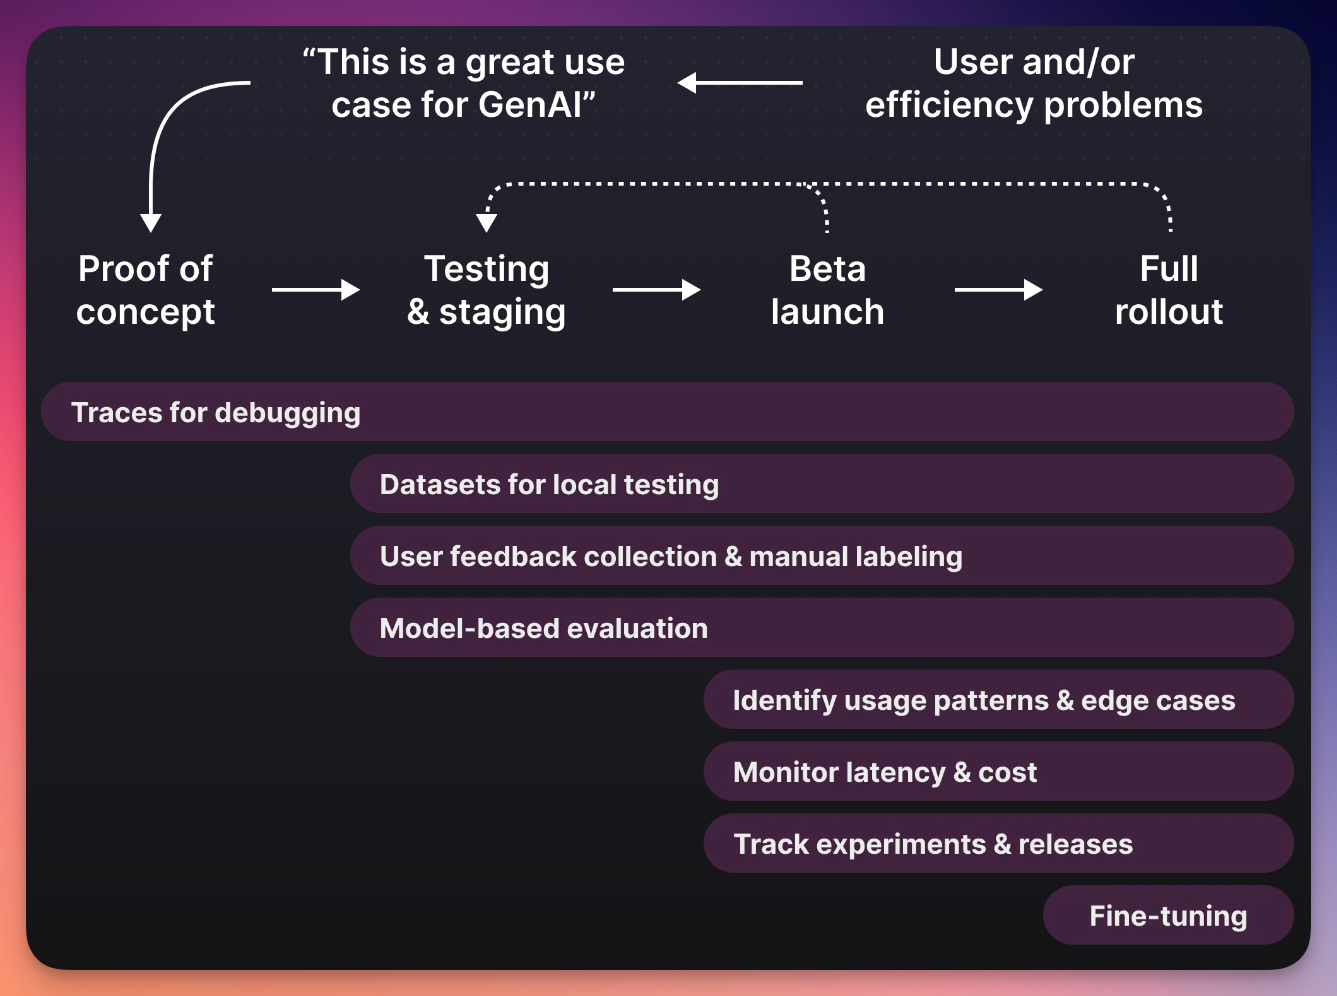

First, we need to set-up Langfuse
1. Step: Open Langfuse user interface (UI) and sign in <br>
2. Step: Create new project (in this cookbook the project is going to be called 'cookbook001') <br>
3. Step: Create new API keys <br>
4. Step: Copy API keys (secret API key will only be visible once) and set them as environmental variables in your environment <br>


Second, we authenticate ourself with our secret and public key

In [6]:
# Set Langfuse secret and public access keys
os.environ["LANGFUSE_SECRET_KEY"] = "Insert your Langfuse secret access key here"
os.environ["LANGFUSE_PUBLIC_KEY"] = "Insert your Langfuse public access key here"

## Base model

Let us assume we were given an AI agent. In this example, the data scientist behind the model chose to build a retrieval augmented generative (RAG) architecture using the Langchain framework. The model is built as follows

In [7]:
# Initialize retriever
embedding = OpenAIEmbeddings(model='text-embedding-ada-002')

In [8]:
# Create vector database using similarity search algorithms in FAISS
vectorstore = FAISS.from_texts(professional_profiles, embedding)
retriever = vectorstore.as_retriever()

In [9]:
# Create prompt template
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

In [10]:
# Initialiize prompt template
prompt = ChatPromptTemplate.from_template(template)

In [11]:
# Initialize model
model = ChatOpenAI()

In [12]:
# Initialize rag model
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

After putting the system into production, the integration has encountered significant issues. We have been receiving numerous complaints regarding the new system. The AI agent is reportedly delivering inaccurate information.

Example: A notable example of these issues is highlighted in the inquiry about Harrison Jones' former employer. In this instance, the AI agent repeatedly provided incorrect data, exemplifying its propensity for errors in certain scenarios.

Now we have been selected to fix the issue. We start to examine the error by invoking the agent with the reported error.

In [13]:
question = "At which company was harrison jones working?"

In [14]:
# Run chain with question
answer = chain.invoke(question)

In [15]:
print(
    f"Input question: {question} \n"
    f"Expected answer: CloudTech Solutions \n"
    f"RAG answer: {answer}"
)

Input question: At which company was harrison jones working? 
Expected answer: CloudTech Solutions 
RAG answer: Harrison Jones was working at CloudTech Solutions.


That is weird, right? <p>
The AI agent seems to output the right answer ('CloudTech Solutions'). But users persist that the system is not working right. We would have to monitor what users are actually putting in and getting out of the system to see, understand, and solve the issue.

But could we do to recreate and locate the error?

## Traces in Langfuse

LLM apps use increasingly complex abstractions (chains, agents with tools, advanced prompts). The nested traces in Langfuse help to understand what is going on and get to the root cause of problems.

### First use of traces

Let us start by creating a single trace to monitor one single call of the AI agent.

In [16]:
# Initiate langfuse
langfuse = Langfuse()

In [17]:
# Create new trace
trace = langfuse.trace(CreateTrace(name="my_first_trace"))

Switching back to the UI, we can see that we have created a trace with the name 'my_first_trace'.

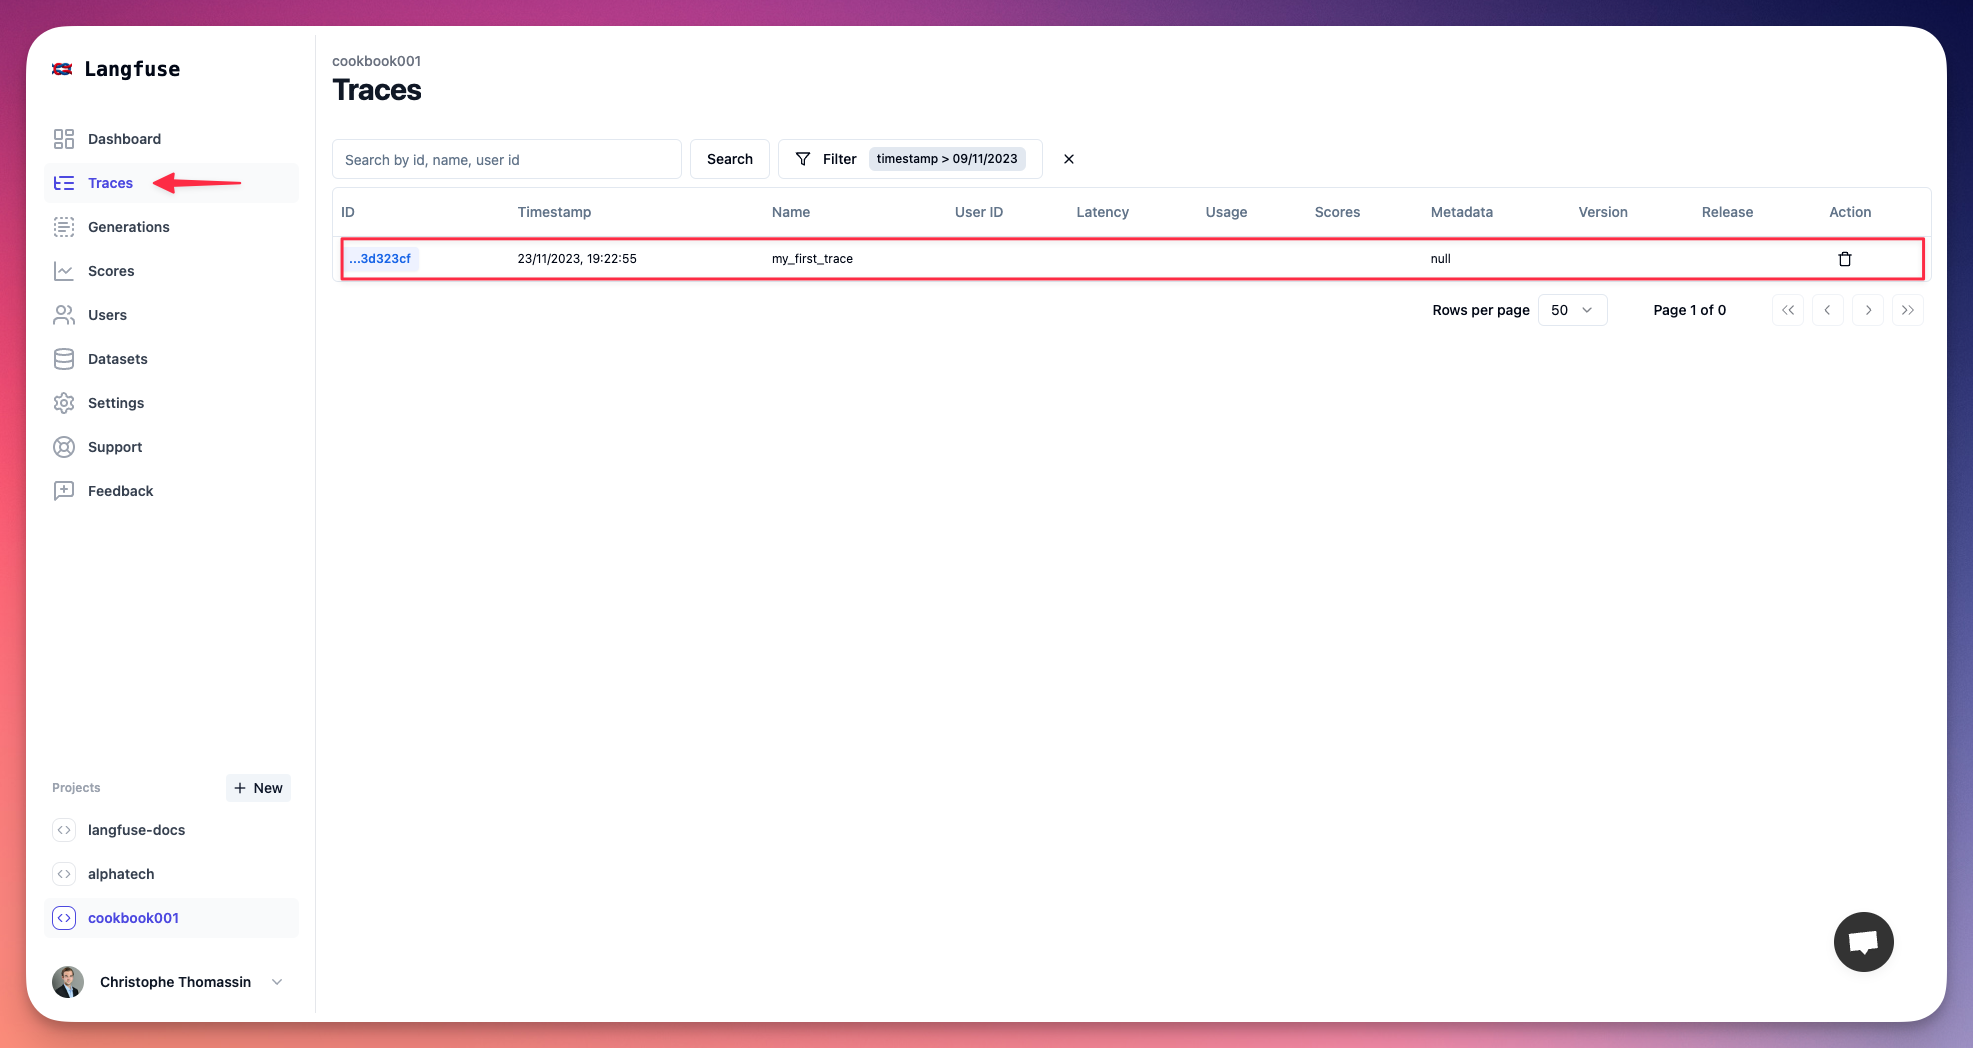

Let us now invoke the RAG architecture and trace the call using Langfuse's Langchain integration (since we used Langchain to build our system). We provide the handler of our trace as a callback to trace the prompt through the AI agent.

In [18]:
# Get handler for trace
handler = trace.get_langchain_handler()

In [19]:
# Run chain with question and provide handler as callback
answer = chain.invoke(question, config={'callbacks':[handler]})

In [20]:
# The command get_trace_url() allows us to view and share our trace in the webbrowser
trace.get_trace_url()

'https://cloud.langfuse.com/trace/84f15412-fb6a-4c6c-aa6a-87bb67361b72'

If we follow the URL above (we could also see the trace through the UI) we can see the trace of the execution in our browser. In general, a trace gives us more details about the structure of our architecture and in- and output of each layer.

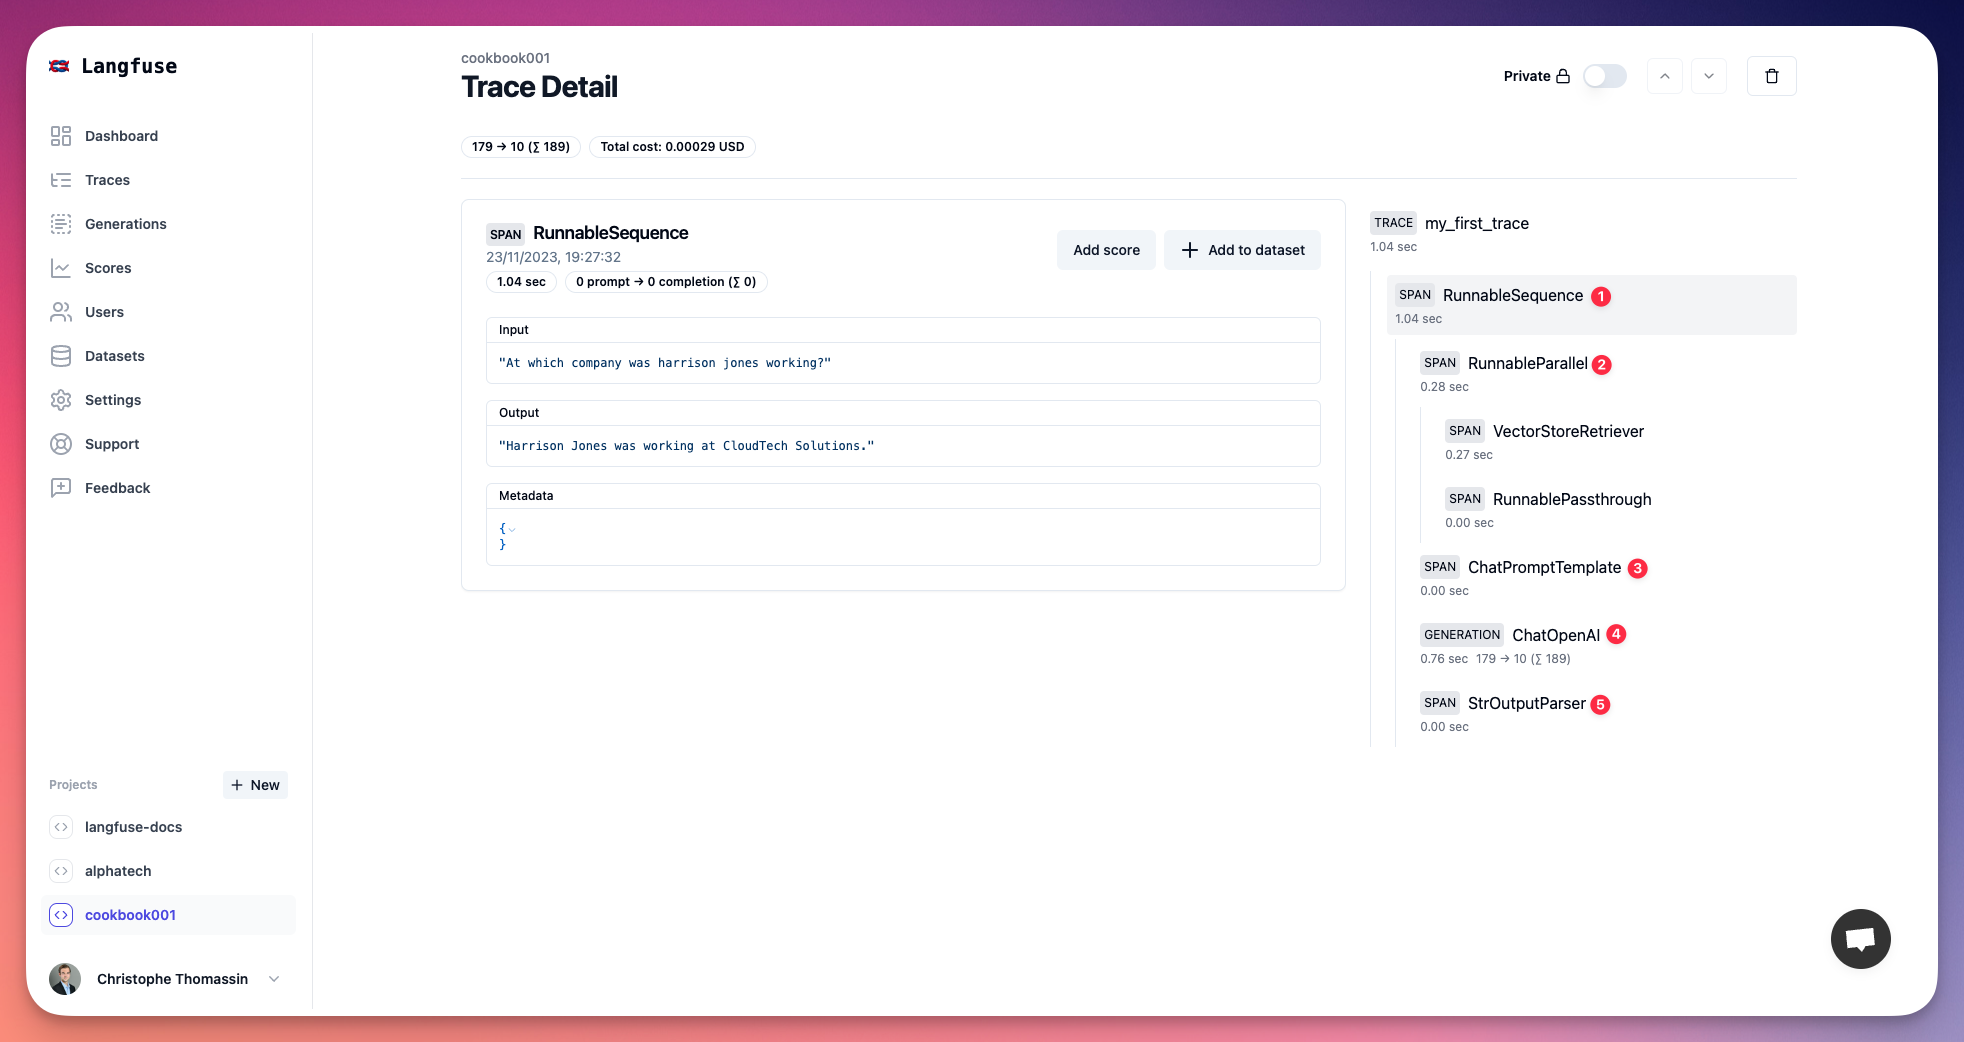

We can see our trace consists of one observation (span 'RunnableSequence') which has 4 child observations (span 'RunnableParallel', span 'ChatPromptTemplate', generation 'ChatOpenAI', and span 'StrOutputParser') on its own. The input of the span 'RunnableSequence' is our input question ("At which company was harrison jones working?") and the output is the answer of the agent ("Harrison Jones was working at CloudTech Solutions."). Let us have a quick look in each observation of the trace 'my_first_trace'. For more in-depth information on the function of each observation, please consult the [Langchain documentation](https://python.langchain.com/docs/get_started/introduction).

1. RunnableSequence (child span of 'alphatech ems'): Describes the entire agent that was built. In Langchain a runnable sequence is a 'sequence of runnables, where the output of each is the input of the next' so in our case the chain we built
2. RunnableParallel (child span of 'RunnableSequence'): Map of multiple runnables to run in parallel. In our case the input (question) and the context are mapped to match the input format of the prompt as defined in the prompt template. The question will just be passed through this span and the context will be retrieved from the FAISS vector database by the embedding. That is why this span has two child spans 'VectorStoreRetriever' and 'RunnablePassthrough'
3. ChatPromptTemplate (child span of 'RunnableSequence'): Previously defined prompt template to provide instructions to the large language model
4. ChatOpenAI (child generation of 'RunnableSequence'): OpenAI chat model ('gpt-3.5-turbo' by default) to answer question based on previous input and prompt template
5. StrOutputParser (child span of 'RunnableSequence'): OutputParser to transform LLM output into string

**Again, we see the agent seems to return the correct solution ("Harrison Jones was working at CloudTech Solutions.").**

What now? We decide to implement langfuse completely into the application to monitor all the prompts made and be able to trace errors in real examples. To do so, we need to know about a few parameters of langfuse traces to enhance our system's analytics capabilities.

Traces can be used for more than just tracing calls of large language model.

### Features of traces

**1. Add releases & versions to traces**

A release tracks the overall version of your application. Commonly it is set to the semantic version or git commit hash of your application.
The version parameter can be added to traces and all observation types (span, generation, event). Thereby, you can track the effect of a new version on the metrics of an object with a specific name using.
[More information here](https://langfuse.com/docs/experimentation)

*Let us initiate langfuse with a release tag of 'v1.0'. In the next step, together with the user definition, we will create a trace with the version tag of our embedding model ("text-embedding-ada-002")*

In [21]:
# Initiate langfuse with release tag 'v1.0'
langfuse = Langfuse(release='v1.0')

**2. Add users to traces**

Mapping data in Langfuse to individual users is easy by passing a unique identifier as the user_id attribute when creating a trace. This will also allow us to perform analytics on users in the UI. [More information here](https://langfuse.com/docs/user-explorer)

*Let us create a test trace with a user_id*

In [22]:
# Create new trace with user_id ExampleUser1 and verion text-embedding-ada-002
test_trace = langfuse.trace(CreateTrace(
    name="my_second_trace",
    user_id="ExampleUser1",
    version="text-embedding-ada-002"
    ))

**3. Add token usage to traces**

When ingesting LLM generations into Langfuse you can add token usage numbers to the generation object. For OpenAI large language models the amount of prompt_tokens (input), completion_tokens (output), and total tokens (sum of input and output) is already retrieved through the OpenAI API call and saved in the trace. Some other models might not provide the token usage directly. In this case one might have to count tokens manually and provide them to the generation. [More information here](https://langfuse.com/docs/token-usage)

### A first application of traces to log calls to an AI agent

In the following, we are going to write a few functions that will mimic the functioning of an AI agent with the integration of Langfuse. We first write a function to build the agent, then another one to create a trace and invoke the chain with the trace as a handler. Finally, the latter function returns the answer, the trace url and the trace_id.

In [23]:
def build_agent() -> base.RunnableSequence:
  """
  Build and return the chatbot agent.
  The agent is initialized with a database of professional profiles,
  uses a vector store for retrieving information, and answers questions
  based on an OpenAI large language model enriched with a prompt
  template.
  """
  embedding = OpenAIEmbeddings(model='text-embedding-ada-002')

  # Create vector database using similarity search algorithms in FAISS
  vectorstore = FAISS.from_texts(professional_profiles, embedding)
  retriever = vectorstore.as_retriever()

  # Create prompt template
  template = """Answer the question based only on the following context:
  {context}

  Question: {question}
  """

  # Initialiize prompt template
  prompt = ChatPromptTemplate.from_template(template)

  # Initialize model
  model = ChatOpenAI()

  # Initialize rag model
  chain = (
      {"context": retriever, "question": RunnablePassthrough()}
      | prompt
      | model
      | StrOutputParser()
  )
  return chain

In [24]:
def get_employee_information(
        langfuse: Langfuse,
        chain: base.RunnableSequence,
        question: str,
        userid: str = "ExampleUser1",
        embedding_version: str = "text-embedding-ada-002"
) -> Tuple[str, str, str, str]:
    """
    Retrieves information based on a given question and
    traces call with Langfuse's Langchain integration
    """
    # Create a new trace with user ID and version
    trace = langfuse.trace(CreateTrace(
        name="agent_trace",
        user_id=userid,
        version=embedding_version
    ))
    # Get the handler for the language chain
    handler = trace.get_langchain_handler()
    # Invoke the chain with the question and handler
    answer = chain.invoke(question, config={'callbacks': [handler]})

    return question, answer, trace.id, trace.get_trace_url()

Now we can test our application in a concrete example

In [25]:
# Initiate langfuse with release tag 'v1.0'
langfuse = Langfuse(release='v1.0')
# Initialize agent architecture
chain = build_agent()
# Define question
question = "Who from AlphaTech previously worked at BrandVision?"
# Run application (create trace, invoke agent, retrieve & trace answer)
question, answer, id, url = get_employee_information(
    langfuse,
    chain,
    question
    )
# Return question, answer, trace id, and trace url
print(
    f"Input question: {question}\n"
    f"Expected answer: 'Mia Schmidt'\n"
    f"RAG answer: {answer}\n"
    f"The trace {id} is available here: {url}"
)

Input question: Who from AlphaTech previously worked at BrandVision?
Expected answer: 'Mia Schmidt'
RAG answer: Mia Schmidt previously worked at BrandVision and is now part of the digital marketing team at AlphaTech.
The trace 0f8a111b-5449-42e4-adfe-320d3de6229c is available here: https://cloud.langfuse.com/trace/0f8a111b-5449-42e4-adfe-320d3de6229c


## Scores in Langfuse

Nice! Now we can finally have an idea of what our users are actually doing with our application but how do we find the problematic cases in which our chat bot fails to answer questions correctly?

Would not it be nice to have a metric telling us how well our agent is doing? Luckily Langfuse got you covered by introducing scores for large language models. While there are an unlimited number of attributes a model can be evaluated on (Quality, Security, Style), there are 4 different ways to score a trace in Langfuse.

1. Manuel scores: Review traces/generations and add scores manually in the UI <br>
2. User-feedback: User evaluate the response to their prompt themselves (e.g., thumbs up/thumbs down) <br>
3. Model-based: Using a model of how a human would use a proposed system to obtain predicted usability measures by calculation or simulation <br>
4. Custom: Define a custom metric for your use-case to evaluate the model <br>
[More information here](https://langfuse.com/docs/scores)

We want to implement an user feedback option for users. The data science team already took care of implementing the new feature. Let us write an additional function that adds the user feedback to the trace if provided.

Assumption: <br> Feedback is collected via positive/negative feedback (👍/:-1) with optional comments. Thus, the application gives back user_score and user_feedback where user_score is defined as:
- User did not give feedback: user_score = 0, user_feedback = None
- User did give 'thumbs up' feedback: user_score = 1, user_feedback = None/comment
- User did give 'thumbs up' feedback: user_score = -1, user_feedback = None/comment

In [26]:
def score_trace(
        langfuse: Langfuse,
        trace_id: str,
        user_score: int,
        user_feedback: str
) -> None:
    """
    Adds a user score and comment to a trace.
    """
    # Add score to trace with user's score and comment
    langfuse.score(InitialScore(
        name='User score',
        traceId=trace_id,
        value=user_score,
        comment=user_feedback
    ))

Test scoring function in application

In [27]:
# Initiate langfuse with release tag 'v1.0'
langfuse = Langfuse(release='v1.0')

# Initialize agent architecture
chain = build_agent()

# Define question
question = "Where did Harrison work before joining Alphatech?"

# Run application (create trace, invoke agent, retrieve & trace answer)
question, answer, id, url = get_employee_information(
    langfuse,
    chain,
    question)

# Add user_score to trace
score_trace(
    langfuse,
    id,
    '-1',
    'Wrong answer, Harrison Fisher worked at Kensho'
)

# Return question, answer, trace id, and trace url
print(
    f"Input question: {question} \n"
    f"Expected answer: 'Kensho' \n"
    f"RAG answer: {answer} \n"
    f"The trace {id} is available here {url}"
)

Input question: Where did Harrison work before joining Alphatech? 
Expected answer: 'Kensho' 
RAG answer: Harrison worked at CloudTech Solutions before joining AlphaTech. 
The trace 2fdfa17e-3dcd-4f7d-bab7-842a3b4ca0d9 is available here https://cloud.langfuse.com/trace/2fdfa17e-3dcd-4f7d-bab7-842a3b4ca0d9


Thanks to this new feature we can now understand what is actually not working in our AI agent. Quickly, we find an example of an error. When asking for the employer of 'Harrison Fisher' prior to his job at Alphatech, the agent answered with 'Cloudtech Solutions' instead of 'Kensho'.

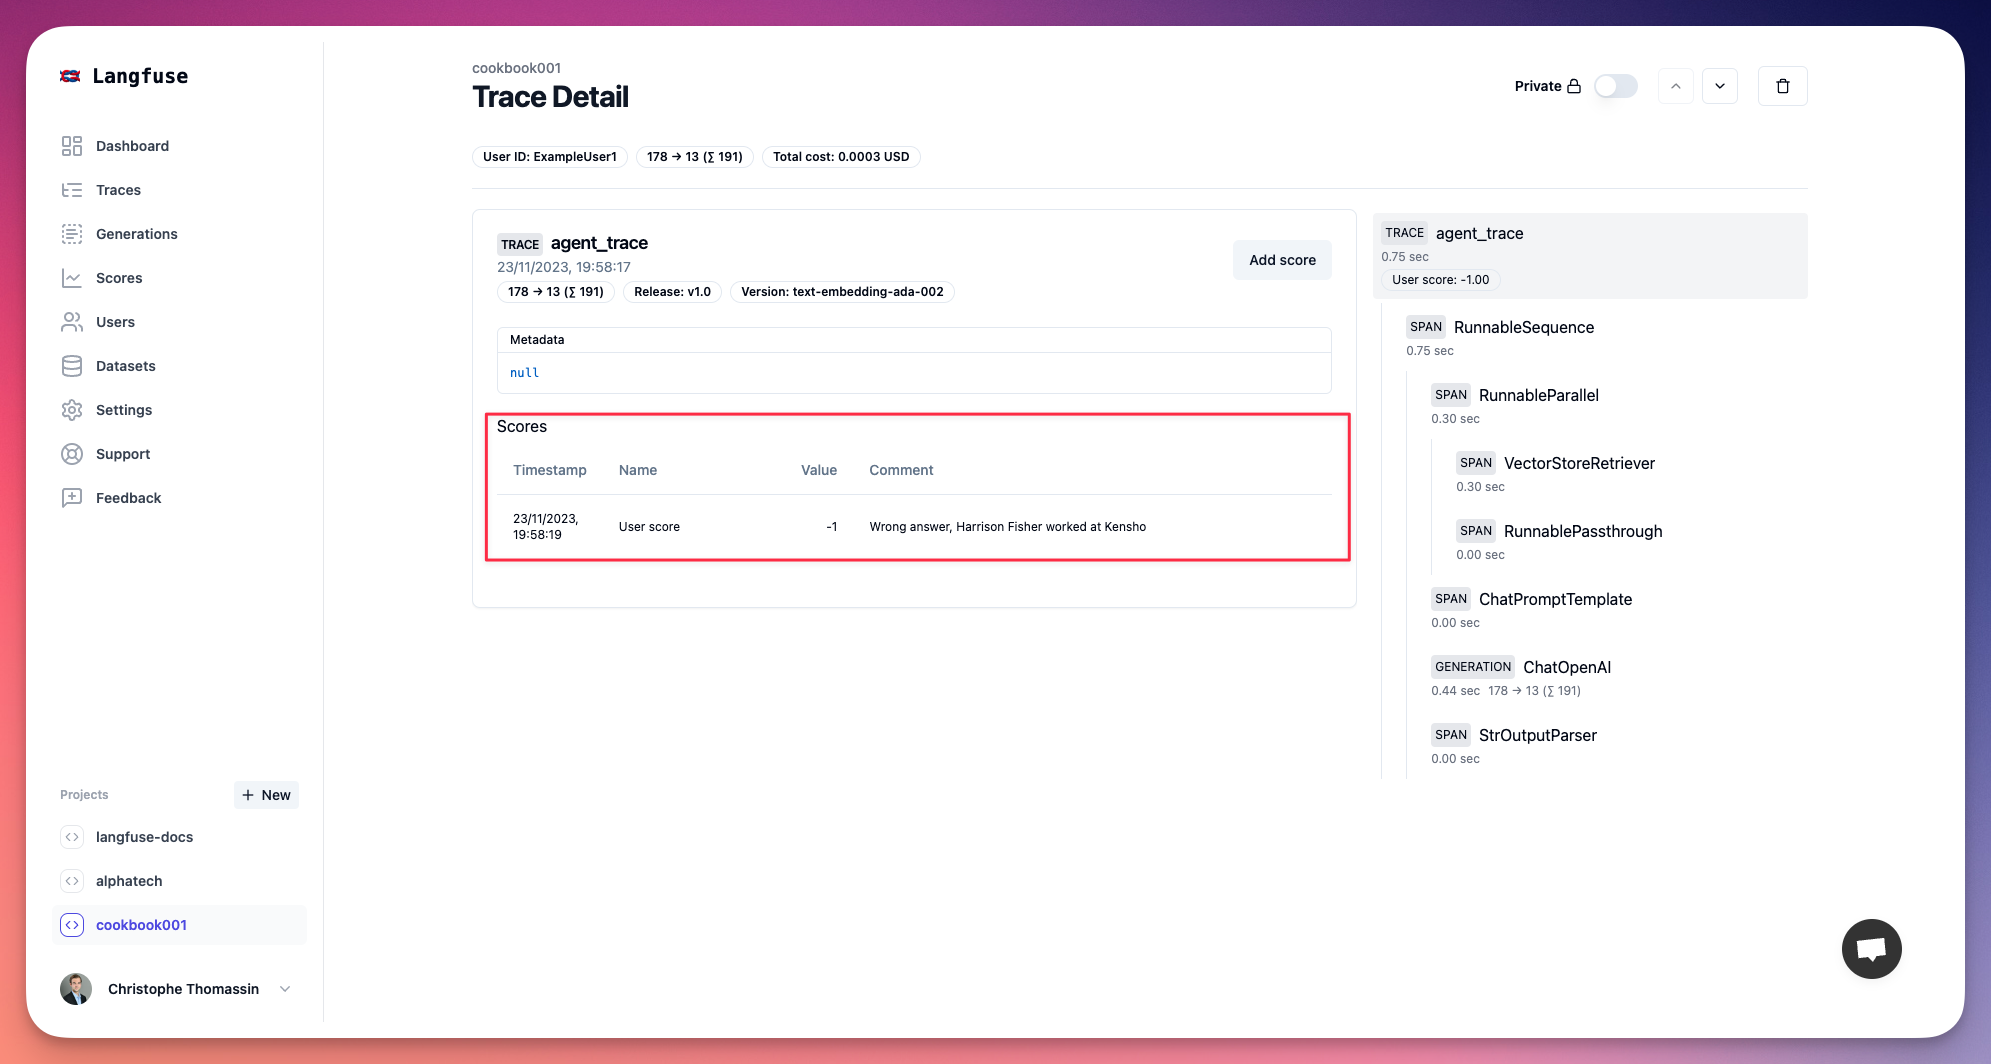

An examination of the trace of the call in langfuse exploits that the user asked for the employer of 'Harrison', so only stated the first name, not the family name. Looking at the VectorStoreRetriever you notice that there are two employees called 'Harrison' in the database, 'Harrison Jones' and 'Harrison Fisher'. The former was employed by 'Cloudtech Solution' which is why the agent returns this solution. To remediate this error we can now either change the prompt template to specify what the chat bot should answer if he does not get the full name or add more instruction into the context database for users.

## Datasets in Langfuse

Now you have seen the power of Langfuse in a real use-case. But it does not stop here. Next, we ask ourselves how one can verify if changes one makes on a application, e.g., changing the prompt template, actually improve the performance of the application. That is were datasets become interesting.

Datasets in Langfuse are a collection of inputs (and expected outputs) of an LLM application. They are used to benchmark new releases before deployment to production. Datasets can be incrementally created from new edge cases found in production.

[More information here](https://langfuse.com/docs/datasets)

Let us define a set of sample prompts to benchmark our agent and explore the impact of the change in the prompt template as mentioned before. To do so, we will also have to define a new score.



Note: Do not run the following section on datasets multiple times without changing the name of dataset. Otherwise the dataset will be extended by the question-answer in every run and thus, the computational costs will increase.

In [28]:
# Initialize dataset
dataset = langfuse.create_dataset(CreateDatasetRequest(name="my_first_dataset"))

In [29]:
# Define dataset with question-answer pairs
local_items = [
    {
      "input": {
        "question": "Where did Harrison Fisher work before joining AlphaTech?"
      },
      "expected_output": "Kensho"
    },
    {
      "input": {
        "question": "What was Emily Becker's role at her previous job?"
      },
      "expected_output": "Senior Developer, AI and Machine Learning"
    },
    {
      "input": {
        "question": "Which city is Noah Schmidt based in?"
      },
      "expected_output": "New York City"
    },
    {
      "input": {
        "question": "What is Harrison Jones's specialization?"
      },
      "expected_output": "Cloud Computing, Cybersecurity"
    },
    {
      "input": {
        "question": "What is Emily Fisher's current position at AlphaTech?"
      },
      "expected_output": "Lead Designer, Mobile Applications"
    },
    {
      "input": {
        "question": "What was Liam's previous role?"
      },
      "expected_output": "Project Manager"
    },
    {
      "input": {
        "question": "Where is Sophia currently working?"
      },
      "expected_output": "Network Infrastructure"
    },
    {
      "input": {
        "question": "What is Noah's expertise area at AlphaTech?"
      },
      "expected_output": "AI-Driven Analytics"
    },
    {
      "input": {
        "question": "What was Mia Schmidt's former job title?"
      },
      "expected_output": "Marketing Strategist"
    },
    {
      "input": {
        "question": "What is Ethan's focus area in his current role?"
      },
      "expected_output": "IT Security"
    },
    {
      "input": {
        "question": "Which city does Isabella Fisher reside in?"
      },
      "expected_output": "Las Vegas"
    },
    {
      "input": {
        "question": "What technology does Mason Jones specialize in at AlphaTech?"
      },
      "expected_output": "VR and AR Development"
    },
    {
      "input": {
        "question": "What department does Charlotte lead at AlphaTech?"
      },
      "expected_output": "QA Department"
    },
    {
      "input": {
        "question": "What was Logan Becker's specialization at his previous job?"
      },
      "expected_output": "Network Security Analyst"
    },
    {
      "input": {
        "question": "In which city does Amelia Schmidt live?"
      },
      "expected_output": "Minneapolis"
    },
    {
      "input": {
        "question": "What is Jacob Fisher's current role at AlphaTech?"
      },
      "expected_output": "Front-End Development Oversight"
    },
    {
      "input": {
        "question": "What team does Zoe Schmidt lead at AlphaTech?"
      },
      "expected_output": "Business Intelligence Team"
    },
    {
      "input": {
        "question": "What is Benjamin Becker's current position at AlphaTech?"
      },
      "expected_output": "Senior Software Architect"
    },
    {
      "input": {
        "question": "What is Lily Jones's role in cloud services at AlphaTech?"
      },
      "expected_output": "Cloud Services Management"
    },
    {
      "input": {
        "question": "What was William's previous job before AlphaTech?"
      },
      "expected_output": "Tech Support Manager"
    }
]

In [30]:
# Upload dataset to langfuse
for item in local_items:
  langfuse.create_dataset_item(
    CreateDatasetItemRequest(
        dataset_name="my_first_dataset",
        input=item["input"],
        expected_output=item["expected_output"]
    )
)

We can see in the UI that the dataset has been created and that it contains twenty items containing question-answer pairs to test our application.

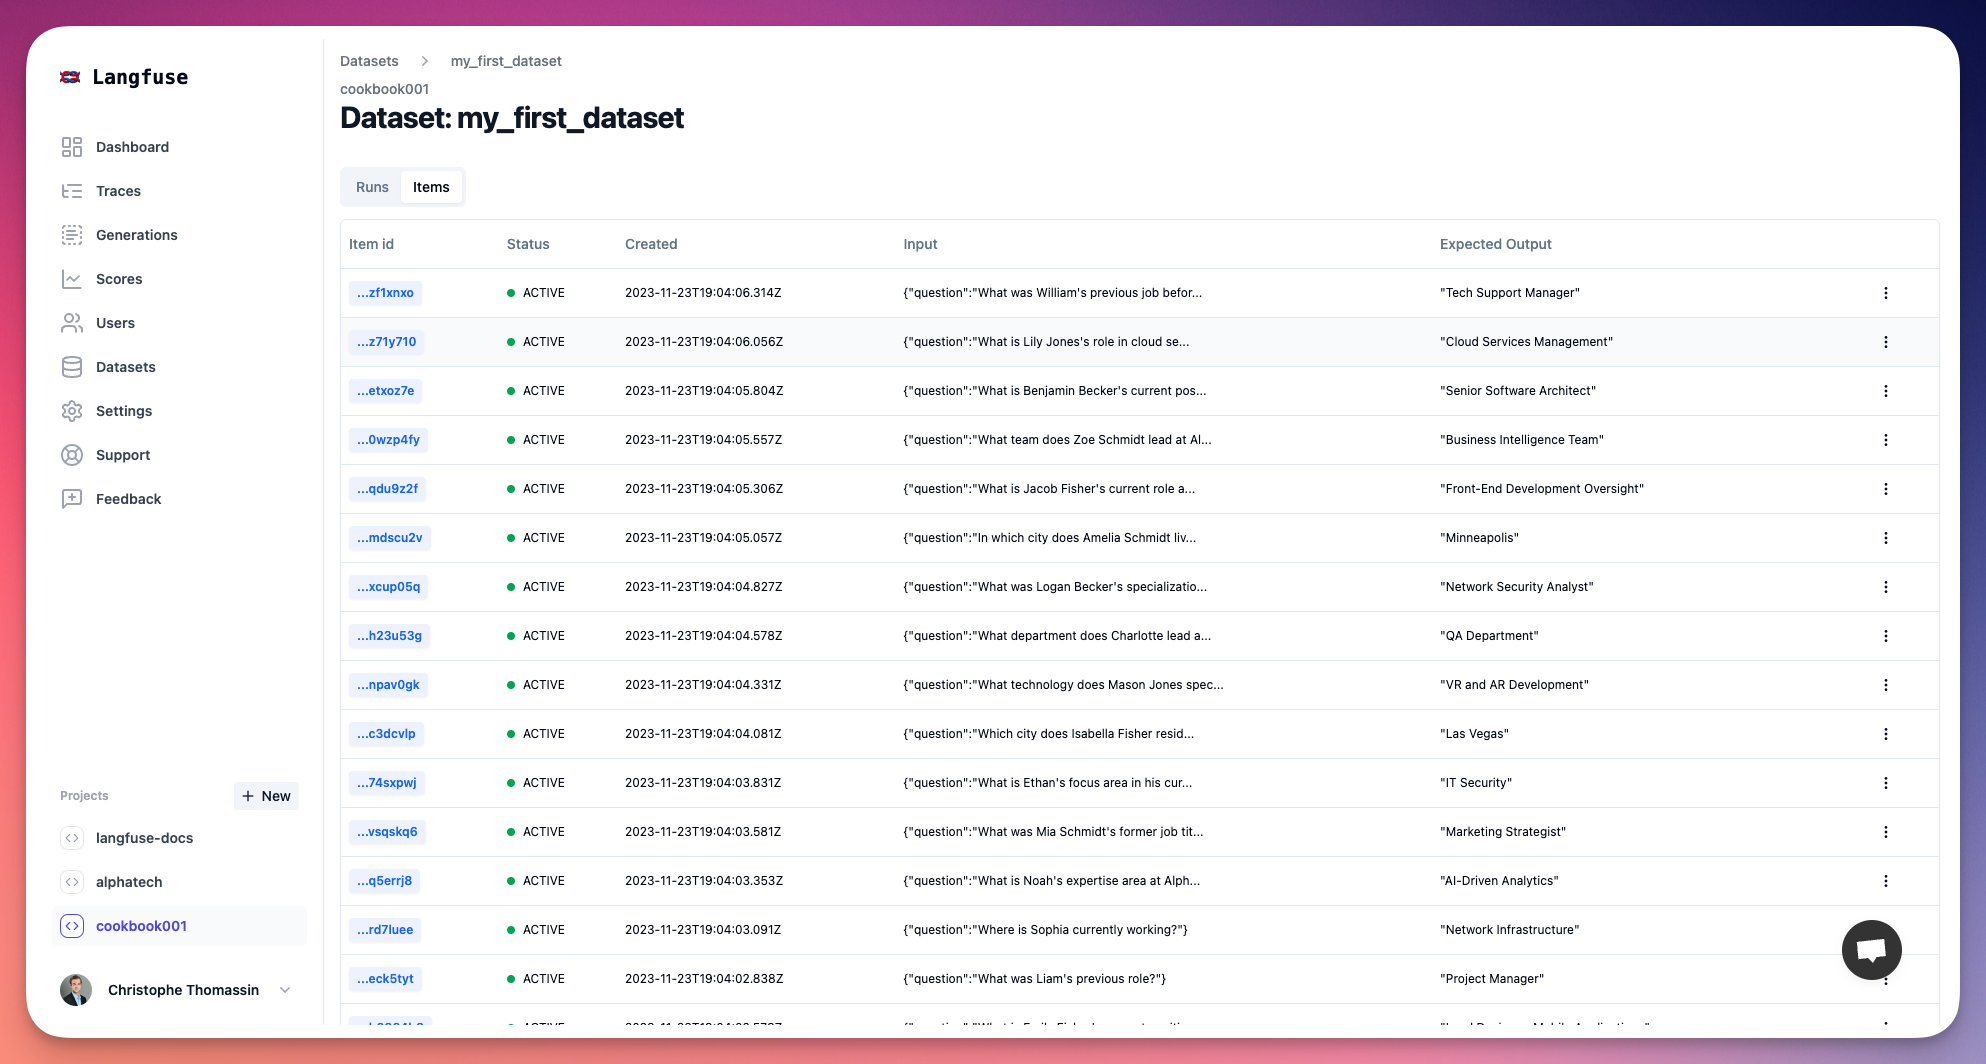

Now we want to run the dataset on our agent to measure its performance. Therefore, we first have to define a scoring method to evaluate the accuracy of our agent on a single invocation. After executing a dataset run we will be able to compute a score for the entire run (average of all item scores) and see the traces and scores for all items.

To evaluate the agent's performance, we will use a custom scoring method focused on content rather than exact phrasing. This involves tokenizing and stemming both the expected and actual responses to standardize word forms. Then, we will calculate a fractional score based on the proportion of expected words found in the actual response, yielding a score between 0 (no match) and 1 (perfect match).

In [31]:
def tokenize_and_stem(text):
    """
    Tokenize and stem the given text.
    """
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return set(stemmed_tokens)

def score_chatbot_response(response, expected_output):
    """
    Score the chatbot's response against the expected output.
    """
    # Tokenize and stem both response and expected output
    response_tokens = tokenize_and_stem(response)
    expected_tokens = tokenize_and_stem(expected_output)

    # Check for token inclusion
    matched_tokens = response_tokens.intersection(expected_tokens)
    total_expected_tokens = len(expected_tokens)

    # Calculate scoring
    return len(matched_tokens) / total_expected_tokens if total_expected_tokens > 0 else 0.0


# Example usage
response = "Harrison previously worked at Kensho before his tenure at AlphaTech."
expected_output = "Kensho"
score = score_chatbot_response(response, expected_output)
print(f"Score: {score}")

Score: 1.0


Next, we define a function to conduct a run, a sequential invocation of all items in a dataset. After each invocation, we add the score computed by our previously defined scoring function ```score_chat_response``` to the run item.



In [32]:
def conduct_run(
    langfuse: Langfuse,
    chain: base.RunnableSequence,
    experiment_name: str,
    dataset_name: str = "my_first_dataset"
) -> None:
  dataset = langfuse.get_dataset(dataset_name)

  for item in dataset.items:
    # Get dataset item handler
    handler = item.get_langchain_handler(run_name=experiment_name)
    # Execute langchain chain
    answer = chain.invoke(item.input["question"], config={'callbacks':[handler]})
    # Create score and add to rootSpan of run
    handler.rootSpan.score(CreateScore(
      name="check_keywords",
      value=score_chatbot_response(answer, item.expected_output)
    ))

In [33]:
# Conduct run
conduct_run(langfuse, chain, "first test")

A quick look into the UI shows us that our run was successful. Although the average accuracy of our agent on the 20 test questions is only at 79% (see picture at the end of the chapter).

As suggested earlier, we are going to change the prompt template of the agent in the hope of improving our score. Let us ask the model to give back the answer to the question for all persons with the same name. This way we should be able to mitigate the errors similar to the one with 'Harrison Jones' and 'Harrison Fisher' we discovered earlier.

In [34]:
def build_improved_agent() -> base.RunnableSequence:
  # Initialize retriever
  embedding = OpenAIEmbeddings(model='text-embedding-ada-002')

  # Create vector database using similarity search algorithms in FAISS
  vectorstore = FAISS.from_texts(professional_profiles, embedding)
  retriever = vectorstore.as_retriever()

  # Alter prompt template to answer questions to all persons with same name
  template = """Answer the question based only on the following context.
  If the question contains only the first or the family name of a person,
  please answer the question for all persons with this name.
  Context:
  {context}

  Question: {question}
  """

  # Initialiize prompt template
  prompt = ChatPromptTemplate.from_template(template)

  # Initialize model
  model = ChatOpenAI()

  # Initialize rag model
  chain = (
      {"context": retriever, "question": RunnablePassthrough()}
      | prompt
      | model
      | StrOutputParser()
  )
  return chain

In [35]:
# Build improved agent
improved_chain = build_improved_agent()

In [36]:
# Conduct test run with improved agent
conduct_run(langfuse, improved_chain, "second test")

But with a quick into the UI we discover that the average score on the question dataset is 79% again (see picture at the end of the chapter).

There has to be another issue with the agent. After some testing with the tracing functionality of langfuse, we find two different issues.
1. The retriever only gives back 4 items from the dataset (default). In some cases the similarity search of the retriever is not able to retrieve the data samples of all persons with the same name
2. The OpenAI large language model ```gpt-3.5-turbo```, which we are currently using, is performing far worse on large context prompts than ```gpt-4``` <br>

Based on these findings we decide to increase the context size to 7 to find a trade-off between enough context to solve the answer and small costs due to limited number of input tokens. Also we change the model from ```gpt-3.5-turbo``` to  ```gpt-4```. Let's test our new agent.



In [37]:
def build_final_agent() -> base.RunnableSequence:
  # Initialize retriever
  embedding = OpenAIEmbeddings(model='text-embedding-ada-002')

  # Create vector database using similarity search algorithms in FAISS
  vectorstore = FAISS.from_texts(professional_profiles, embedding)
  retriever = vectorstore.as_retriever(
      search_type="mmr",
      search_kwargs={'k': 7}
      )

  # Create prompt template
  template = """Answer the question based only on the following context.
  If the question contains only the first or the family name of a person,
  please answer the question for all persons with this name.
  Context:
  {context}

  Question: {question}
  """

  # Initialiize prompt template
  prompt = ChatPromptTemplate.from_template(template)

  # Initialize model
  model = ChatOpenAI(model="gpt-4")

  # Initialize rag model
  chain = (
      {"context": retriever, "question": RunnablePassthrough()}
      | prompt
      | model
      | StrOutputParser()
  )
  return chain

In [38]:
# Build final agent
final_chain = build_final_agent()

In [39]:
# Conduct test run with final agent
conduct_run(langfuse, final_chain, "third test")

Now, we can see that our model is performing much better with a score 89%. One can go one and look into the traces that are not scoring '1.0' to further improve the agent although the remaining errors seem fairly individual at first glance (e.g., answer writes 'virtual reality' instead of 'vr' which is identical for our scoring function).

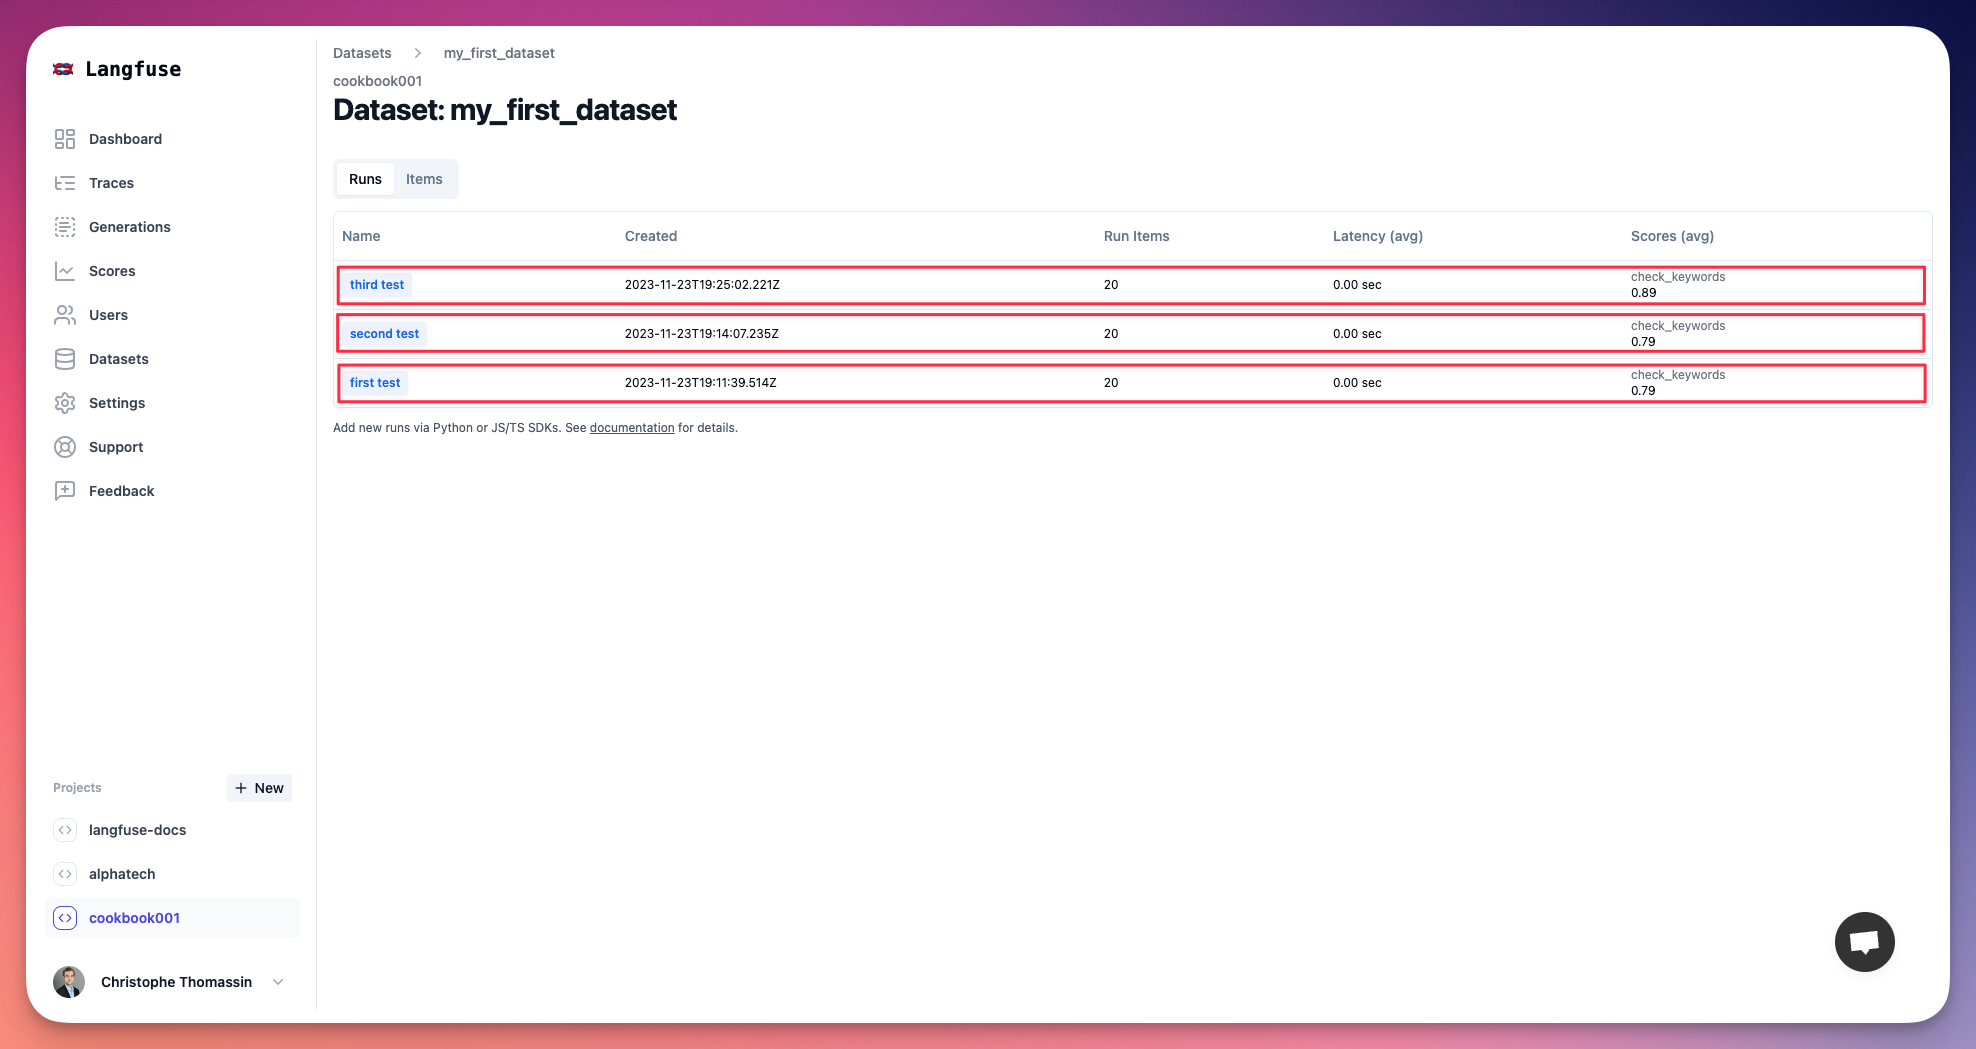

In [40]:
print(final_chain.invoke(question))

Harrison Jones worked at CloudTech Solutions before joining AlphaTech. Harrison Fisher worked at Kensho before joining AlphaTech.


Great! We see the chatbot answers the question correctly.

## Analytics in Langfuse

Langfuse analytics derives actionable insights from production data. The analytics dashboard gives us an overview over the total number of traces, model costs, scores (empty by now), traces over  time, model usage over time (in costs or tokens used), user consumptions, latency per call, and more. Below is a snapshot of the dashboard after executing all the code above.


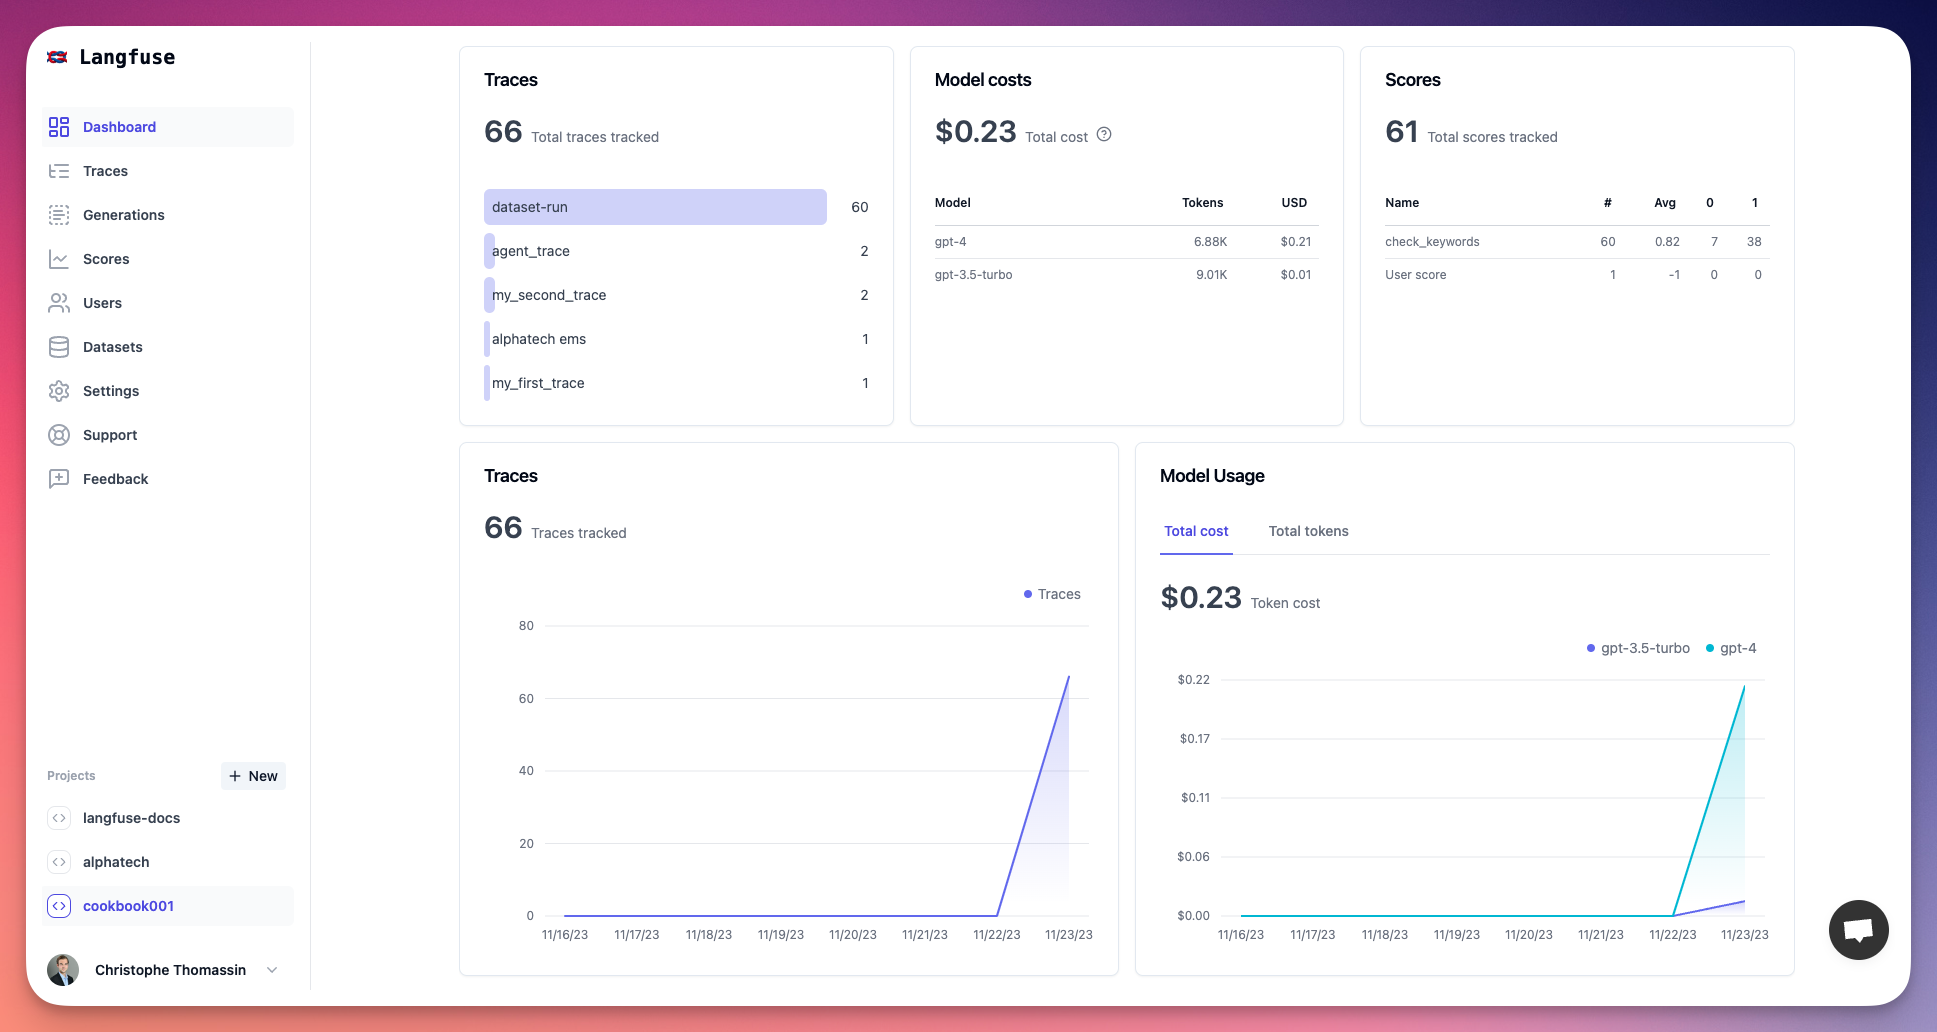

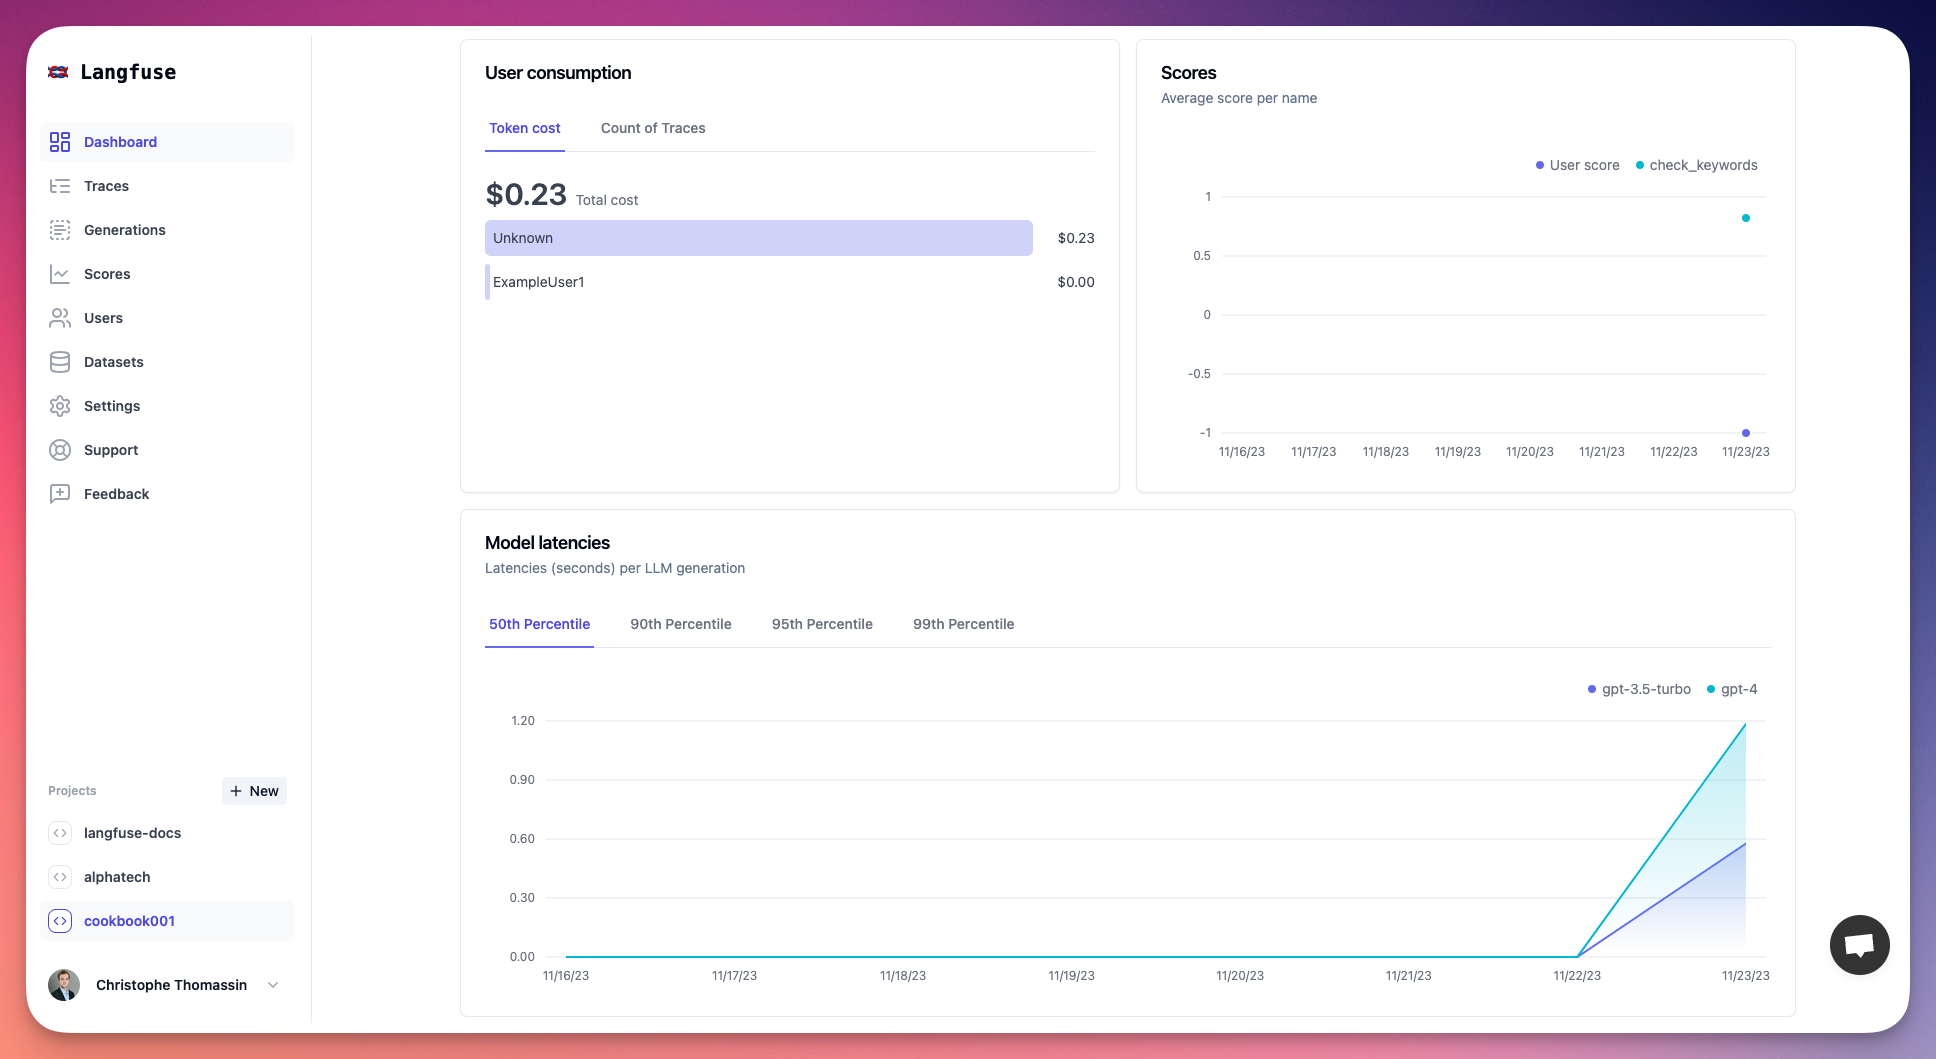